In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv("COVID19_line_list_data.csv")
df = df.dropna(subset=["age", "death"])
df.head()

,id,case_in_country,reporting date,Unnamed: 3,summary,location,country,gender,age,symptom_onset,...,recovered,symptom,source,link,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26
0,1,NaN,1/20/2020,NaN,First confirmed imported COVID-19 pneumonia pa...,"Shenzhen, Guangdong",China,male,66.0,01/03/20,...,0,NaN,Shenzhen Municipal Health Commission,http://wjw.sz.gov.cn/wzx/202001/t20200120_1898...,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,1/20/2020,NaN,First confirmed imported COVID-19 pneumonia pa...,Shanghai,China,female,56.0,1/15/2020,...,0,NaN,Official Weibo of Shanghai Municipal Health Co...,https://www.weibo.com/2372649470/IqogQhgfa?fro...,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,1/21/2020,NaN,First confirmed imported cases in Zhejiang: pa...,Zhejiang,China,male,46.0,01/04/20,...,0,NaN,Health Commission of Zhejiang Province,http://www.zjwjw.gov.cn/art/2020/1/21/art_1202...,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,1/21/2020,NaN,new confirmed imported COVID-19 pneumonia in T...,Tianjin,China,female,60.0,NaN,...,0,NaN,人民日报官方微博,https://m.weibo.cn/status/4463235401268457?,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,1/21/2020,NaN,new confirmed imported COVID-19 pneumonia in T...,Tianjin,China,male,58.0,NaN,...,0,NaN,人民日报官方微博,https://m.weibo.cn/status/4463235401268457?,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
def convertDates(s):
    if s != "0" and s != "1":
        return 1
    return int(s)

#Extract Age and Death columns
#Convert death column into 1s and 0s.
ages = df["age"]
deaths = df["death"].apply(convertDates)

ages.value_counts(bins=5), deaths.value_counts()


((38.55, 57.7]    296
 (57.7, 76.85]    237
 (19.4, 38.55]    231
 (76.85, 96.0]     47
 (0.153, 19.4]     32
 Name: age, dtype: int64,
 0    785
 1     58
 Name: death, dtype: int64)

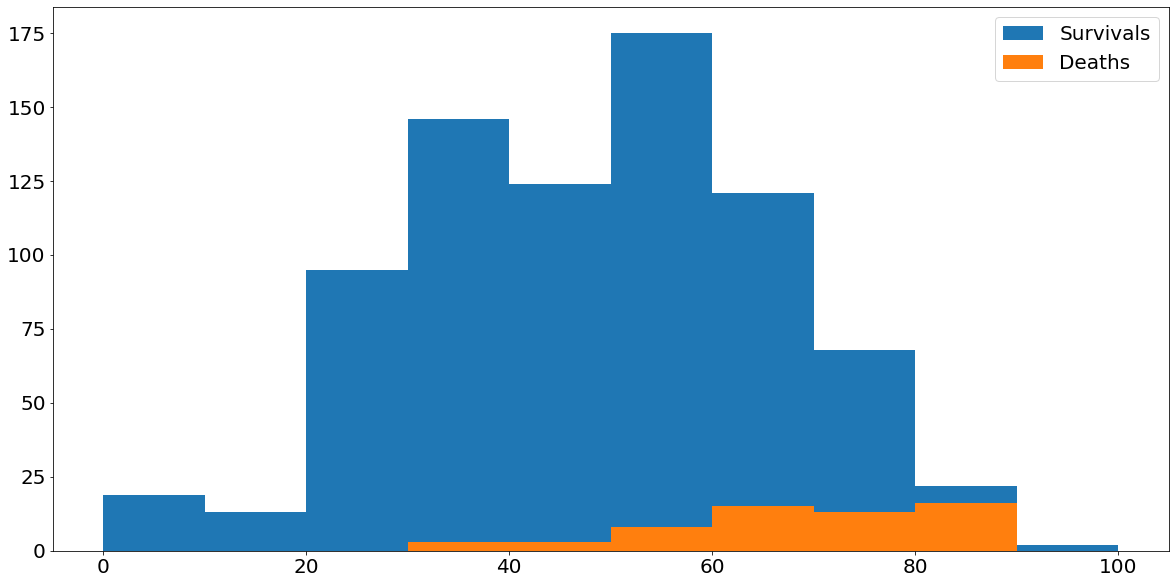

In [227]:
#Do logistic regression on probability of survival as a function of age
from sklearn.linear_model import LogisticRegression as lr
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#Get the probability of death first
x = np.array(ages)
y = np.array(deaths)

p = len(deaths[deaths == 1]) / len(deaths)
bins = np.linspace(0, 100, 11)
freqnegatives = plt.hist(x[y == 0], bins = bins, label="Survivals")
freqpositives = plt.hist(x[y == 1], bins = bins, label="Deaths")

#Get the bin centers. 
#So we can use them later.
binCenters = (bins[1:] + bins[:-1]) / 2
binCenters, bins


#Make it pretty
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig = plt.gcf()
fig.set_size_inches(20,10)

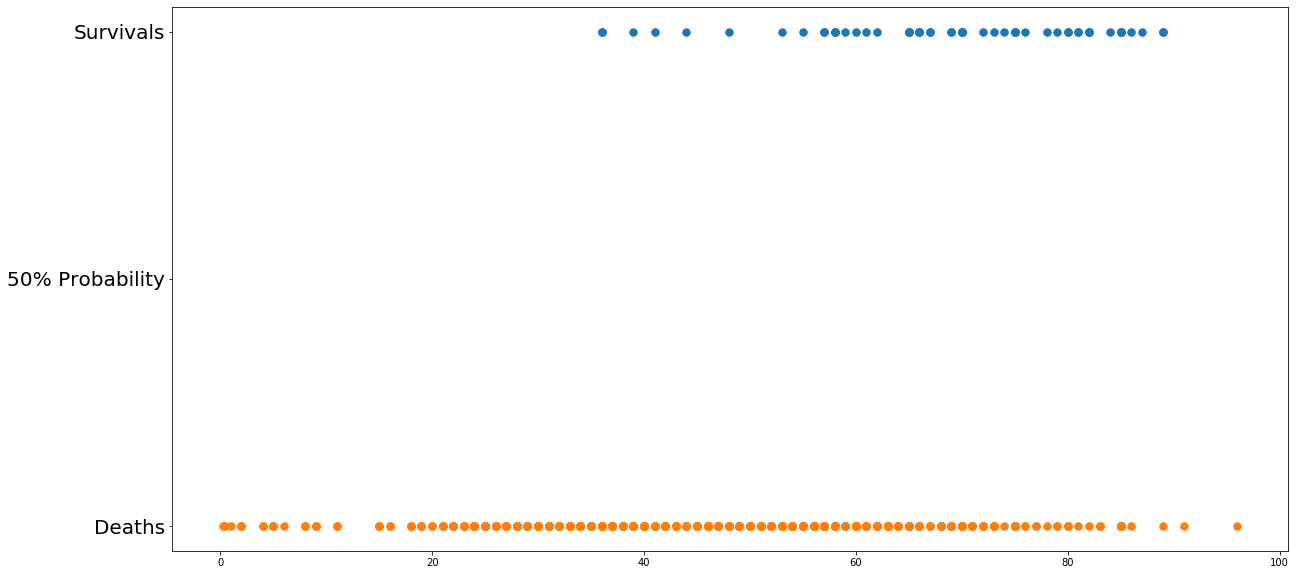

In [228]:
#Make a scatter plot of the deaths and survivals.
positives = x[y == 1]
negatives = x[y == 0]
plt.plot(positives, [1] * len(positives), linestyle="none", marker=".", markersize=15)
plt.plot(negatives, [0] * len(negatives), linestyle="none", marker=".", markersize=15)
plt.yticks([0, 0.5, 1], ["Deaths", "50% Probability", "Survivals"], fontsize=20)
fig = plt.gcf()
fig.set_size_inches(20,10)

0.9289099526066351

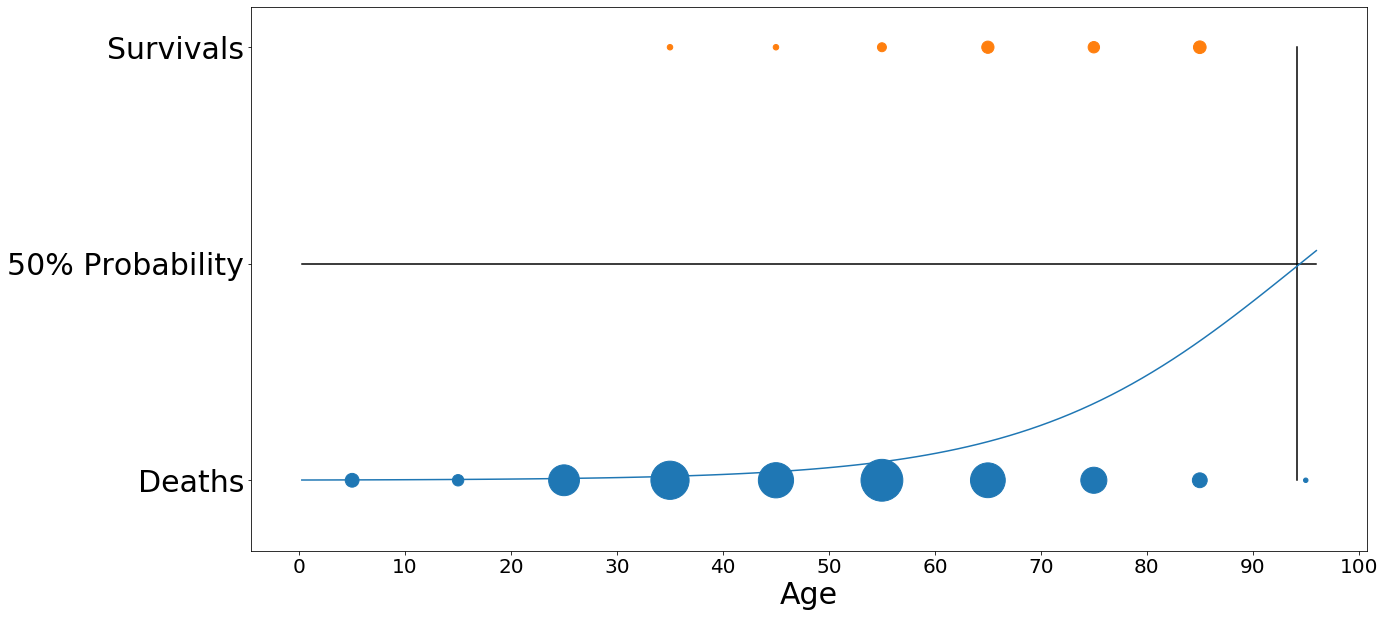

In [135]:
# Perform a train/test split with our data.
# Use the sklearn package to 
# get the a b coefficients in our logistic regression model.
# on one feature (x)

model = lr()
xvector = x.reshape(-1,1)
xtrain, xtest, ytrain, ytest = train_test_split(xvector, y)
model.fit(xtrain, ytrain)
a = model.intercept_[0]
b = model.coef_[0]

#When the probability is 1/2, x0 = -a/b.
x0 = -a / b

# Our logistic regression curve with parameters.
# So we can use our predicted coefficients to make a plot.
def logistic(x, a, b):
    return 1 / (1 + np.exp(-a - x * b))

xspace = np.linspace(min(x), max(x), 100)

#Let's plot the model
_ = plt.plot([x0, x0],[0, 1], label="50% Probability", color="black")
_ = plt.plot([min(x), max(x)], [1/2] * 2, color="black")
_ = plt.plot(xspace, ypredicted)
_ = plt.scatter(binCenters, [0] * len(binCenters), s=10 * freqnegatives[0], label="Deaths")
_ = plt.scatter(binCenters, [1] * len(binCenters), s=10 * freqpositives[0], label="Survivals")

#And make it pretty
plt.xlabel("Age", fontsize=30)
plt.yticks([0, 0.5, 1], ["Deaths", "50% Probability", "Survivals"], fontsize=30)
plt.xticks(bins, fontsize=20)
fig = plt.gcf();
fig.set_size_inches(20,10)



In [142]:
# Get the accuracy of our prediction.
# in 2 different ways
ypredict = model.predict(xtest)
accuracy = sum(ypredict == ytest) / len(ytest)
autoAccuracy = accuracy_score(ytest, ypredict)
accuracy, autoAccuracy

(0.9289099526066351, 0.9289099526066351)

In [203]:
# Run 1000 train/test splits and average the accuracies.
# Get the accuracies, a parameters, and b parameters
# Show their averages.
accs = []
aparams = []
bparams = []
for i in range(1000):
    xtrain, xtest, ytrain, ytest = train_test_split(x.reshape(-1,1),y)
    model = lr()
    model.fit(xtrain, ytrain)
    ypredict = model.predict(xtest)
    accs.append(accuracy_score(ytest, ypredict))
    aparams.append(model.intercept_[0])
    bparams.append(model.coef_[0][0])
np.mean(accs), np.std(accs), np.mean(aparams), np.mean(bparams)

(0.9302322274881515,
 0.014686712874257296,
 -7.338615136727589,
 0.07988367893483155)

Text(0.5, 0.98, 'Slope, intercept, and accuracy distributions for 1000 75:25 train/test splits')

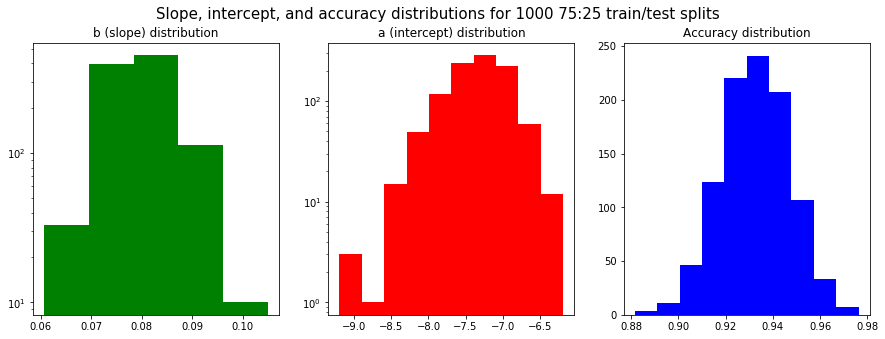

In [226]:
#Plot distributions for the parameters from our train/test splits
fig, axs = plt.subplots(1,3)
axs[0].hist(bparams, bins=5, color="green")
axs[0].set_title(label="b (slope) distribution")
axs[0].set_yscale("log")
axs[1].hist(aparams, color="red")
axs[1].set_title(label="a (intercept) distribution")
axs[1].set_yscale("log")
axs[2].hist(accs, color="blue")
axs[2].set_title(label="Accuracy distribution")
fig.set_size_inches(15,5)
fig.suptitle("Slope, intercept, and accuracy distributions for 1000 75:25 train/test splits",
            size=15)
